# Práctica 5: primer modelo de clasificación n-dimensional

##### Cookbook [@data_mining_2020](https://nbviewer.jupyter.org/github/JacoboGGLeon/data_mining_2020/blob/master/README.ipynb)

## Resources
* [How to Perform Feature Selection with Categorical Data
](https://machinelearningmastery.com/feature-selection-with-categorical-data/)

## Recipe

**Nota:** antes de implementar los siguientes métodos, debemos asegurarnos de que el `DataFrame` sólo contiene características categóricas.

Hay muchas técnicas diferentes para encontrar las características más relevantes, ¿cómo saber cuál usar?. Un enfoque sólido consiste en evaluar los modelos utilizando diferentes métodos, y seleccionar el método que resulte en un modelo con el mejor rendimiento. 

En esta sección, evaluaremos un modelo de Regresión Logística con todas las características en comparación con un modelo construido a partir de características seleccionadas por chi-cuadrado y aquellas características seleccionadas a través de información mutua. La regresión logística es un buen modelo para probar los métodos de selección de características, ya que puede tener un mejor rendimiento si se eliminan del modelo las características irrelevantes.

### Buscando el modelo de clasificación con todas las características

Como primer paso, evaluaremos un modelo de `LogisticRegression` utilizando todas las características disponibles. El modelo se genera dado el conjunto de datos de entrenamiento (train) y se evalúa con el conjunto de datos de prueba (test).

Nota: los resultados pueden variar dada la naturaleza estocástica del algoritmo de aprendizaje. Intenta ejecutar el ejemplo varias veces.

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [38]:
file = './bank.csv'
vars_cat = ['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'y']
df = pd.read_csv(file, sep=';')
df = df[vars_cat]
dataset = df.values
df.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
0,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,nonexistent,no
1,services,single,high.school,no,no,no,telephone,may,fri,nonexistent,no
2,services,married,high.school,no,yes,no,telephone,jun,wed,nonexistent,no
3,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,nonexistent,no
4,admin.,married,university.degree,no,yes,no,cellular,nov,mon,nonexistent,no


In [39]:
df.replace(to_replace='admin.', value='admin', inplace=True)

In [40]:
dataset = df.values

In [41]:
X = dataset[:, :-1]
y = dataset[:,-1]

In [42]:
X = X.astype(str)

In [43]:
 #Preparamos los datos de entrada, X
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc
 
#Preparamos los datos de salida, y
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

In [44]:
#Dividimos los datos de entrada, X, y salida, y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
#Preparamos a X
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
#Preparamos a y
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

#Buscamos el modelo
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_enc, y_train_enc)

#Encontramos el modelo
yhat = model.predict(X_test_enc)

#Evaluamos el desempeño del modelo encontrado
accuracy = accuracy_score(y_test_enc, yhat)
print('Accuracy/exactitud: %.2f' % (accuracy*100), '%')

Accuracy/exactitud: 89.93 %


### Buscando el modelo de clasificación con selección de características vía Chi-cuadrada

In [45]:
#Selección de características
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k=4)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    for i in range(len(fs.scores_)):
        print('Característica %d: %f' % (i, fs.scores_[i]))
    
    plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    return X_train_fs, X_test_fs

Característica 0: 6.967282
Característica 1: 0.564007
Característica 2: 13.873476
Característica 3: 12.506545
Característica 4: 0.027970
Característica 5: 1.680820
Característica 6: 36.563098
Característica 7: 0.379311
Característica 8: 0.031827
Característica 9: 6.005403
Accuracy/exactitud: 89.93 %


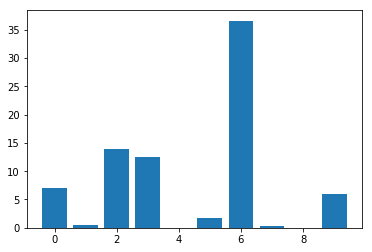

In [46]:
#Dividimos los datos de entrada, X, y salida, y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
#Preparamos a X
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
#Preparamos a y
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
#Selección de características
X_train_fs, X_test_fs = select_features(X_train_enc, y_train_enc, X_test_enc)

#Buscamos el modelo
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_fs, y_train_enc)

#Encontramos el modelo
yhat = model.predict(X_test_fs)

#Evaluamos el desempeño del modelo encontrado
accuracy = accuracy_score(y_test_enc, yhat)
print('Accuracy/exactitud: %.2f' % (accuracy*100), '%')

### Buscando el modelo de clasificación con selección de características vía Información Mutua

In [47]:
#Selección de características
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_classif, k=4)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    for i in range(len(fs.scores_)):
        print('Característica %d: %f' % (i, fs.scores_[i]))
    
    plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    return X_train_fs, X_test_fs

Característica 0: 0.007785
Característica 1: 0.009143
Característica 2: 0.000000
Característica 3: 0.000000
Característica 4: 0.000000
Característica 5: 0.009098
Característica 6: 0.022581
Característica 7: 0.019143
Característica 8: 0.001515
Característica 9: 0.036535
Accuracy/exactitud: 89.93 %


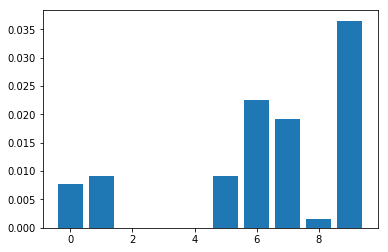

In [48]:
#Dividimos los datos de entrada, X, y salida, y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
#Preparamos a X
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
#Preparamos a y
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
#Selección de características
X_train_fs, X_test_fs = select_features(X_train_enc, y_train_enc, X_test_enc)

#Buscamos el modelo
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_fs, y_train_enc)

#Encontramos el modelo
yhat = model.predict(X_test_fs)

#Evaluamos el desempeño del modelo encontrado
accuracy = accuracy_score(y_test_enc, yhat)
print('Accuracy/exactitud: %.2f' % (accuracy*100), '%')